# IMPORTING PACKAGES AND DATASET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/liver-cirrhosis-stage-classification/liver_cirrhosis.csv')

df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


# BASIC DATASET INFORMATION

In [2]:
df.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

In [3]:
df.isnull().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [4]:
df.dtypes

N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage              int64
dtype: object

In [5]:
df.shape

(25000, 19)

# DATA MANIPULATION AND VISUALIZATION

In [6]:
df['Stage'] = df['Stage'].astype('object')

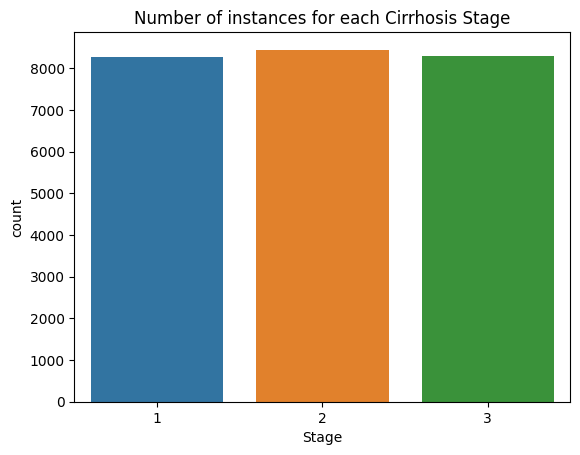

In [7]:
sns.countplot(data = df, x = 'Stage')
plt.title('Number of instances for each Cirrhosis Stage')
plt.show()

There are almost similar numbers of instances for each stages of Cirrhosis in this dataset. So, it's pretty balanced.

In [8]:
categorical_cols = df.select_dtypes('O').columns.tolist()
numerical_cols = df.select_dtypes(exclude = 'O').columns.tolist()

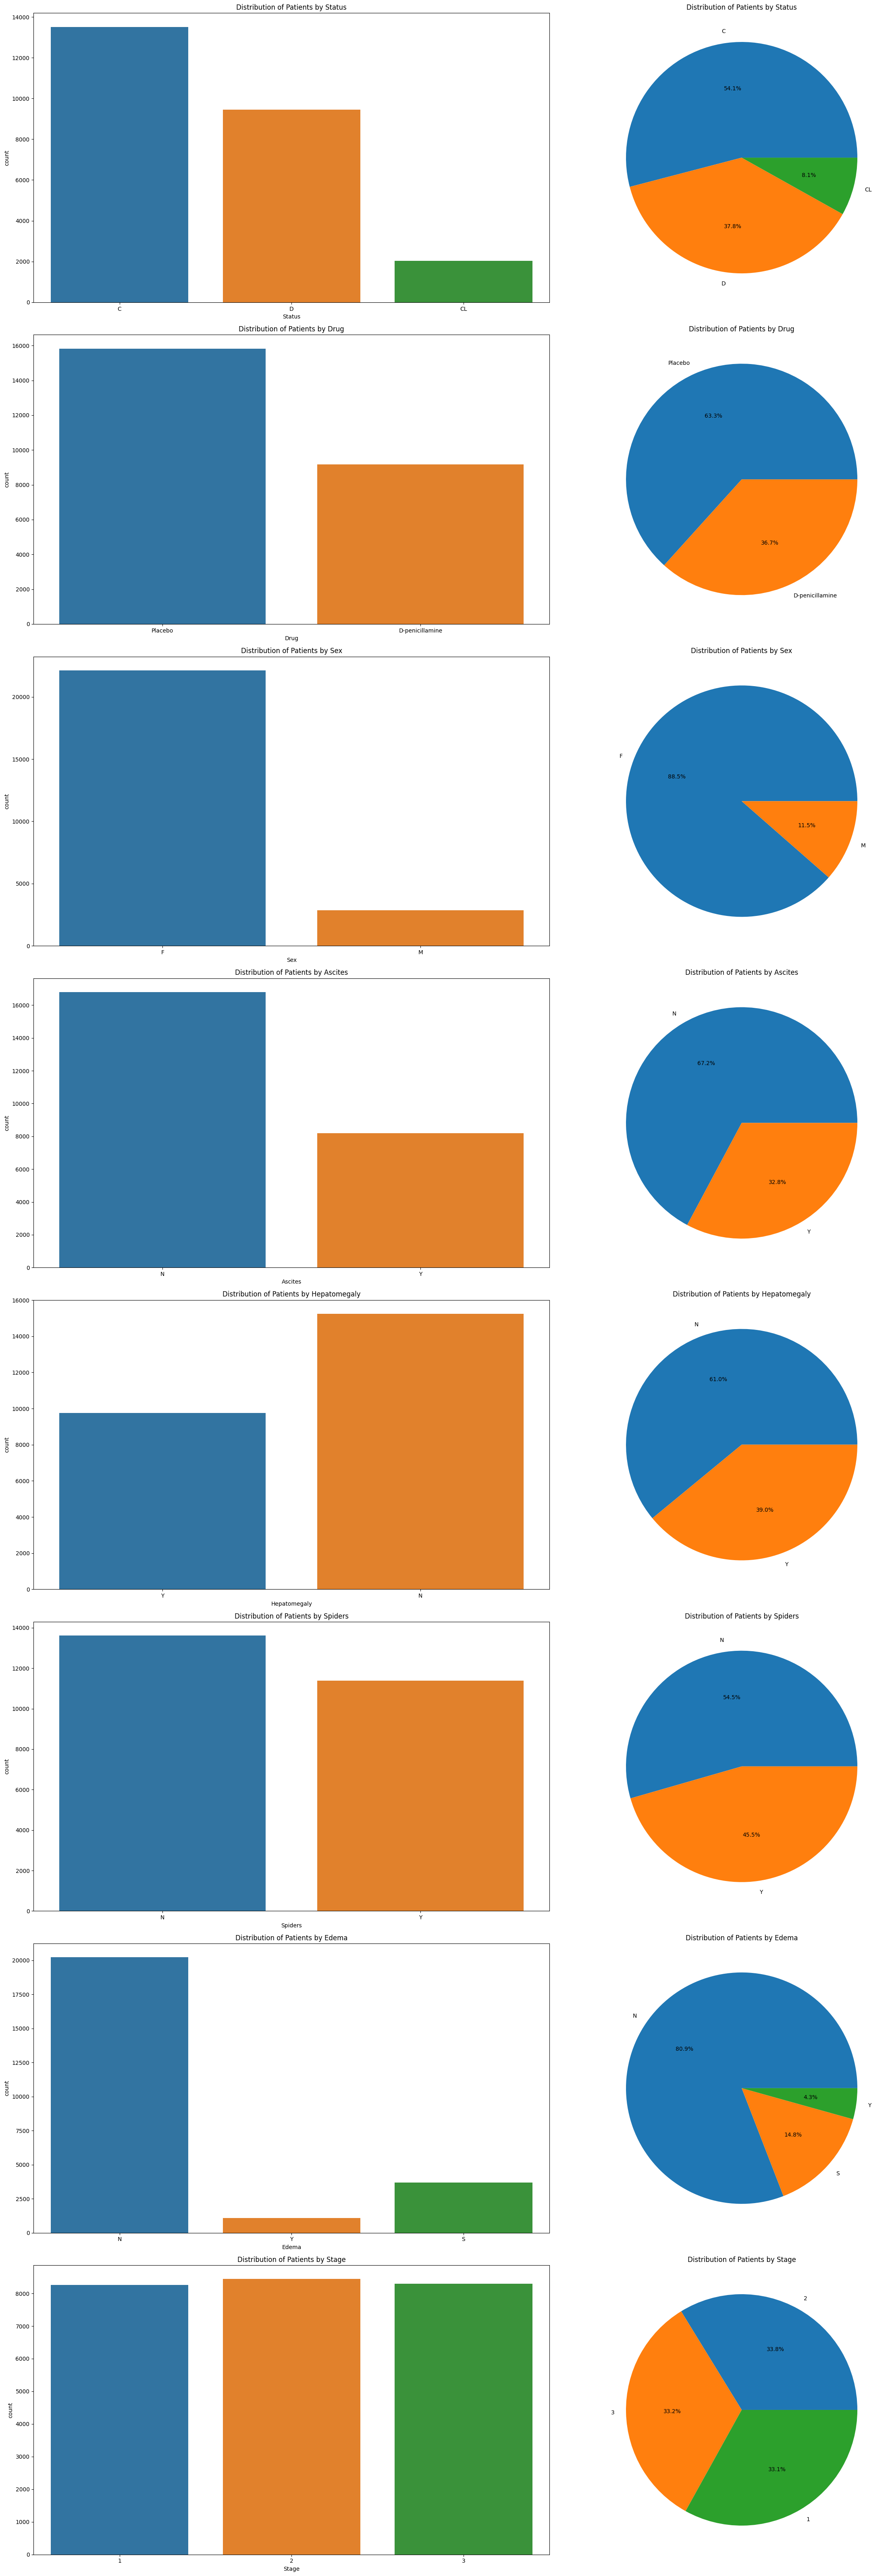

In [9]:
fig, axes = plt.subplots(nrows=round(len(categorical_cols)), ncols=2, figsize = (25,8*len(categorical_cols)))

# Iterate through each column and plot a countplot
for i, column in enumerate(categorical_cols):
   
    sns.countplot(data=df, x=column, ax=axes[i,0])
    axes[i, 0].set_title(f'Distribution of Patients by {column.capitalize()}')
    
    axes[i, 1].pie(df[column].value_counts(), autopct='%1.1f%%', labels=df[column].value_counts().index)
    axes[i, 1].set_title(f'Distribution of Patients by {column.capitalize()}')

    
# Hide any remaining empty subplots
# for j in range(len(categorical_cols), len(axes.flat)):
#     axes.flatten()[j].axis('off')

plt.tight_layout()
plt.show()

<h5><b>TOTAL SUBJECTS IN THIS STUDY ARE 25,000. </b></h5>

1. 54% of the subjects are censored, meaning the patients were alive throughout the study. Almost 38% patients died during the study, and the rest went through Liver Transplantation.
2. 63.3% of the subjects were under Placebo treatment, and the rest were under actual Drug Treatment. 
3. 88.5% of the subjects were female, and there are very few Male subjects.
4. Around 67% of the subjects had Ascites and 61% don't have Hepatomegaly.
6. Number of subjects with Spiders is comparable to subjects without spiders, with the ratio being 55-45. 
7. Almost 20,000 (81%) subjects don't have Edema, while around 5000 (15%) subjects have edema present without diuretics, or edema resolved by diuretics, and a very small amount have Edema regardless of diuretics. 
8. The number of subjects across each stage is evenly balanced.


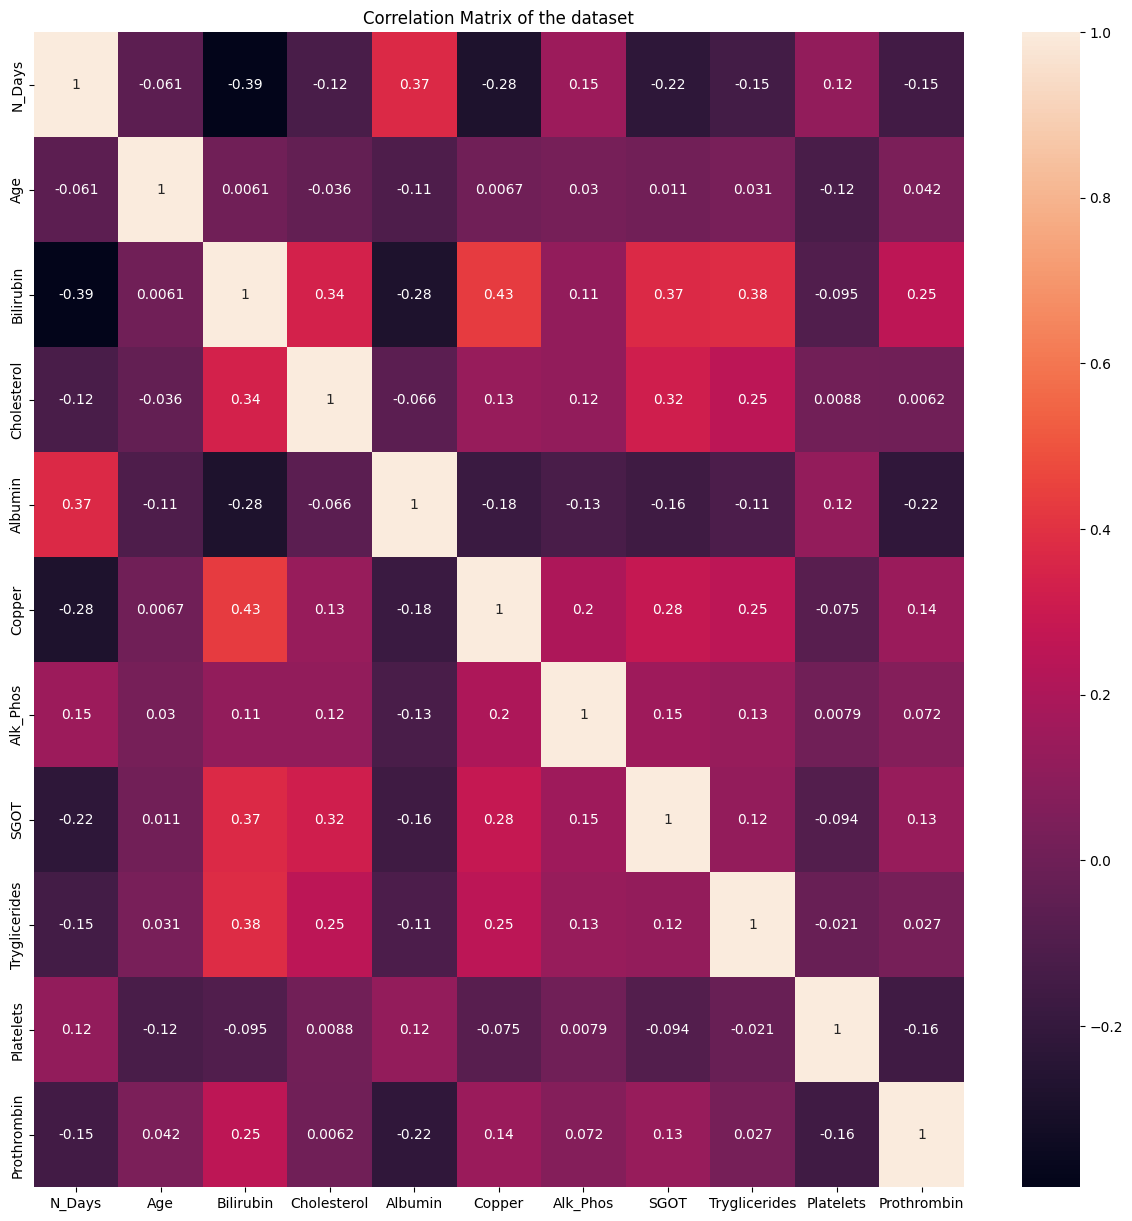

In [10]:
plt.figure(figsize = (15,15))
sns.heatmap(df[numerical_cols].corr(), annot = True)
plt.title('Correlation Matrix of the dataset')
plt.show()

****The features are not correlated to each other at all. Multicollinearity cannot be spotted. ****

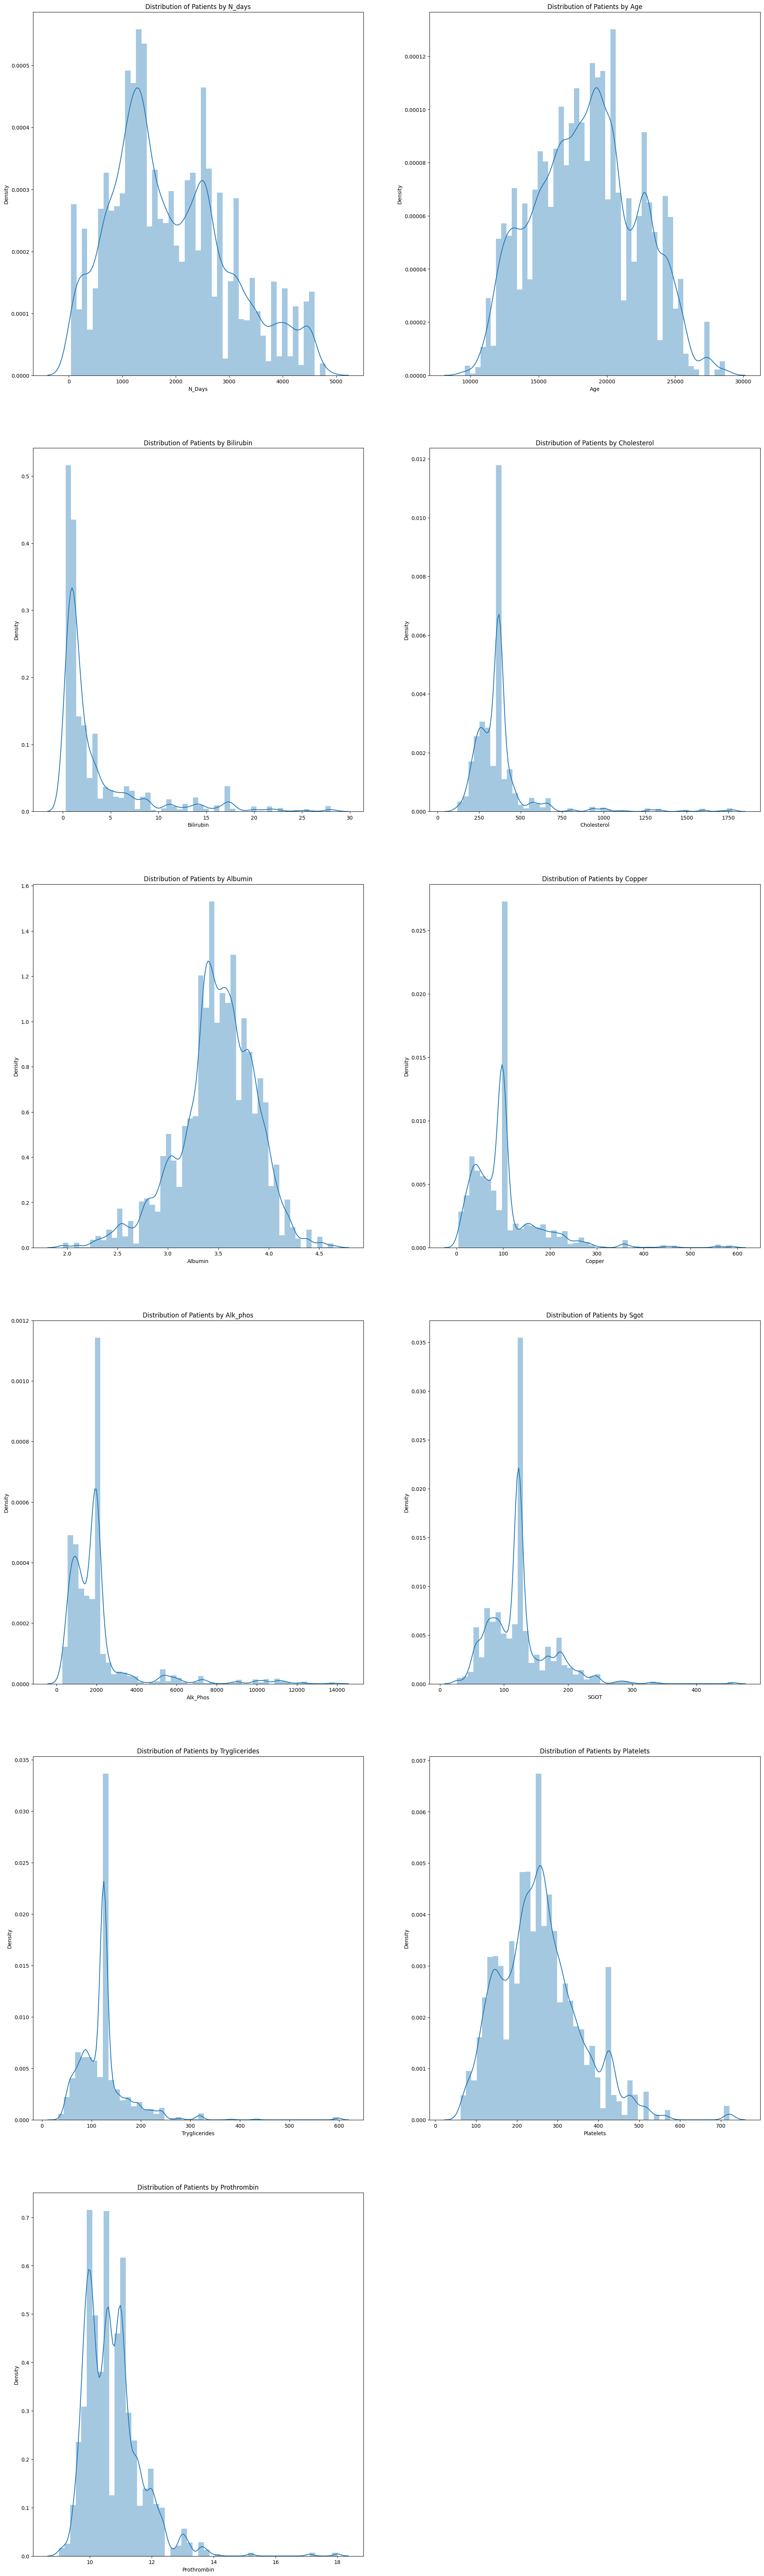

In [11]:
fig, axes = plt.subplots(nrows=round(len(numerical_cols)/2), ncols=2, figsize = (25,8*len(numerical_cols)))

# Iterate through each column and plot a countplot
for i, column in enumerate(numerical_cols):
   
    sns.distplot(df[column], ax=axes[i//2,i%2])
    axes[i//2,i%2].set_title(f'Distribution of Patients by {column.capitalize()}')
    
    

# Hide any remaining empty subplots
for j in range(len(numerical_cols), len(axes.flat)):
    axes.flatten()[j].axis('off')

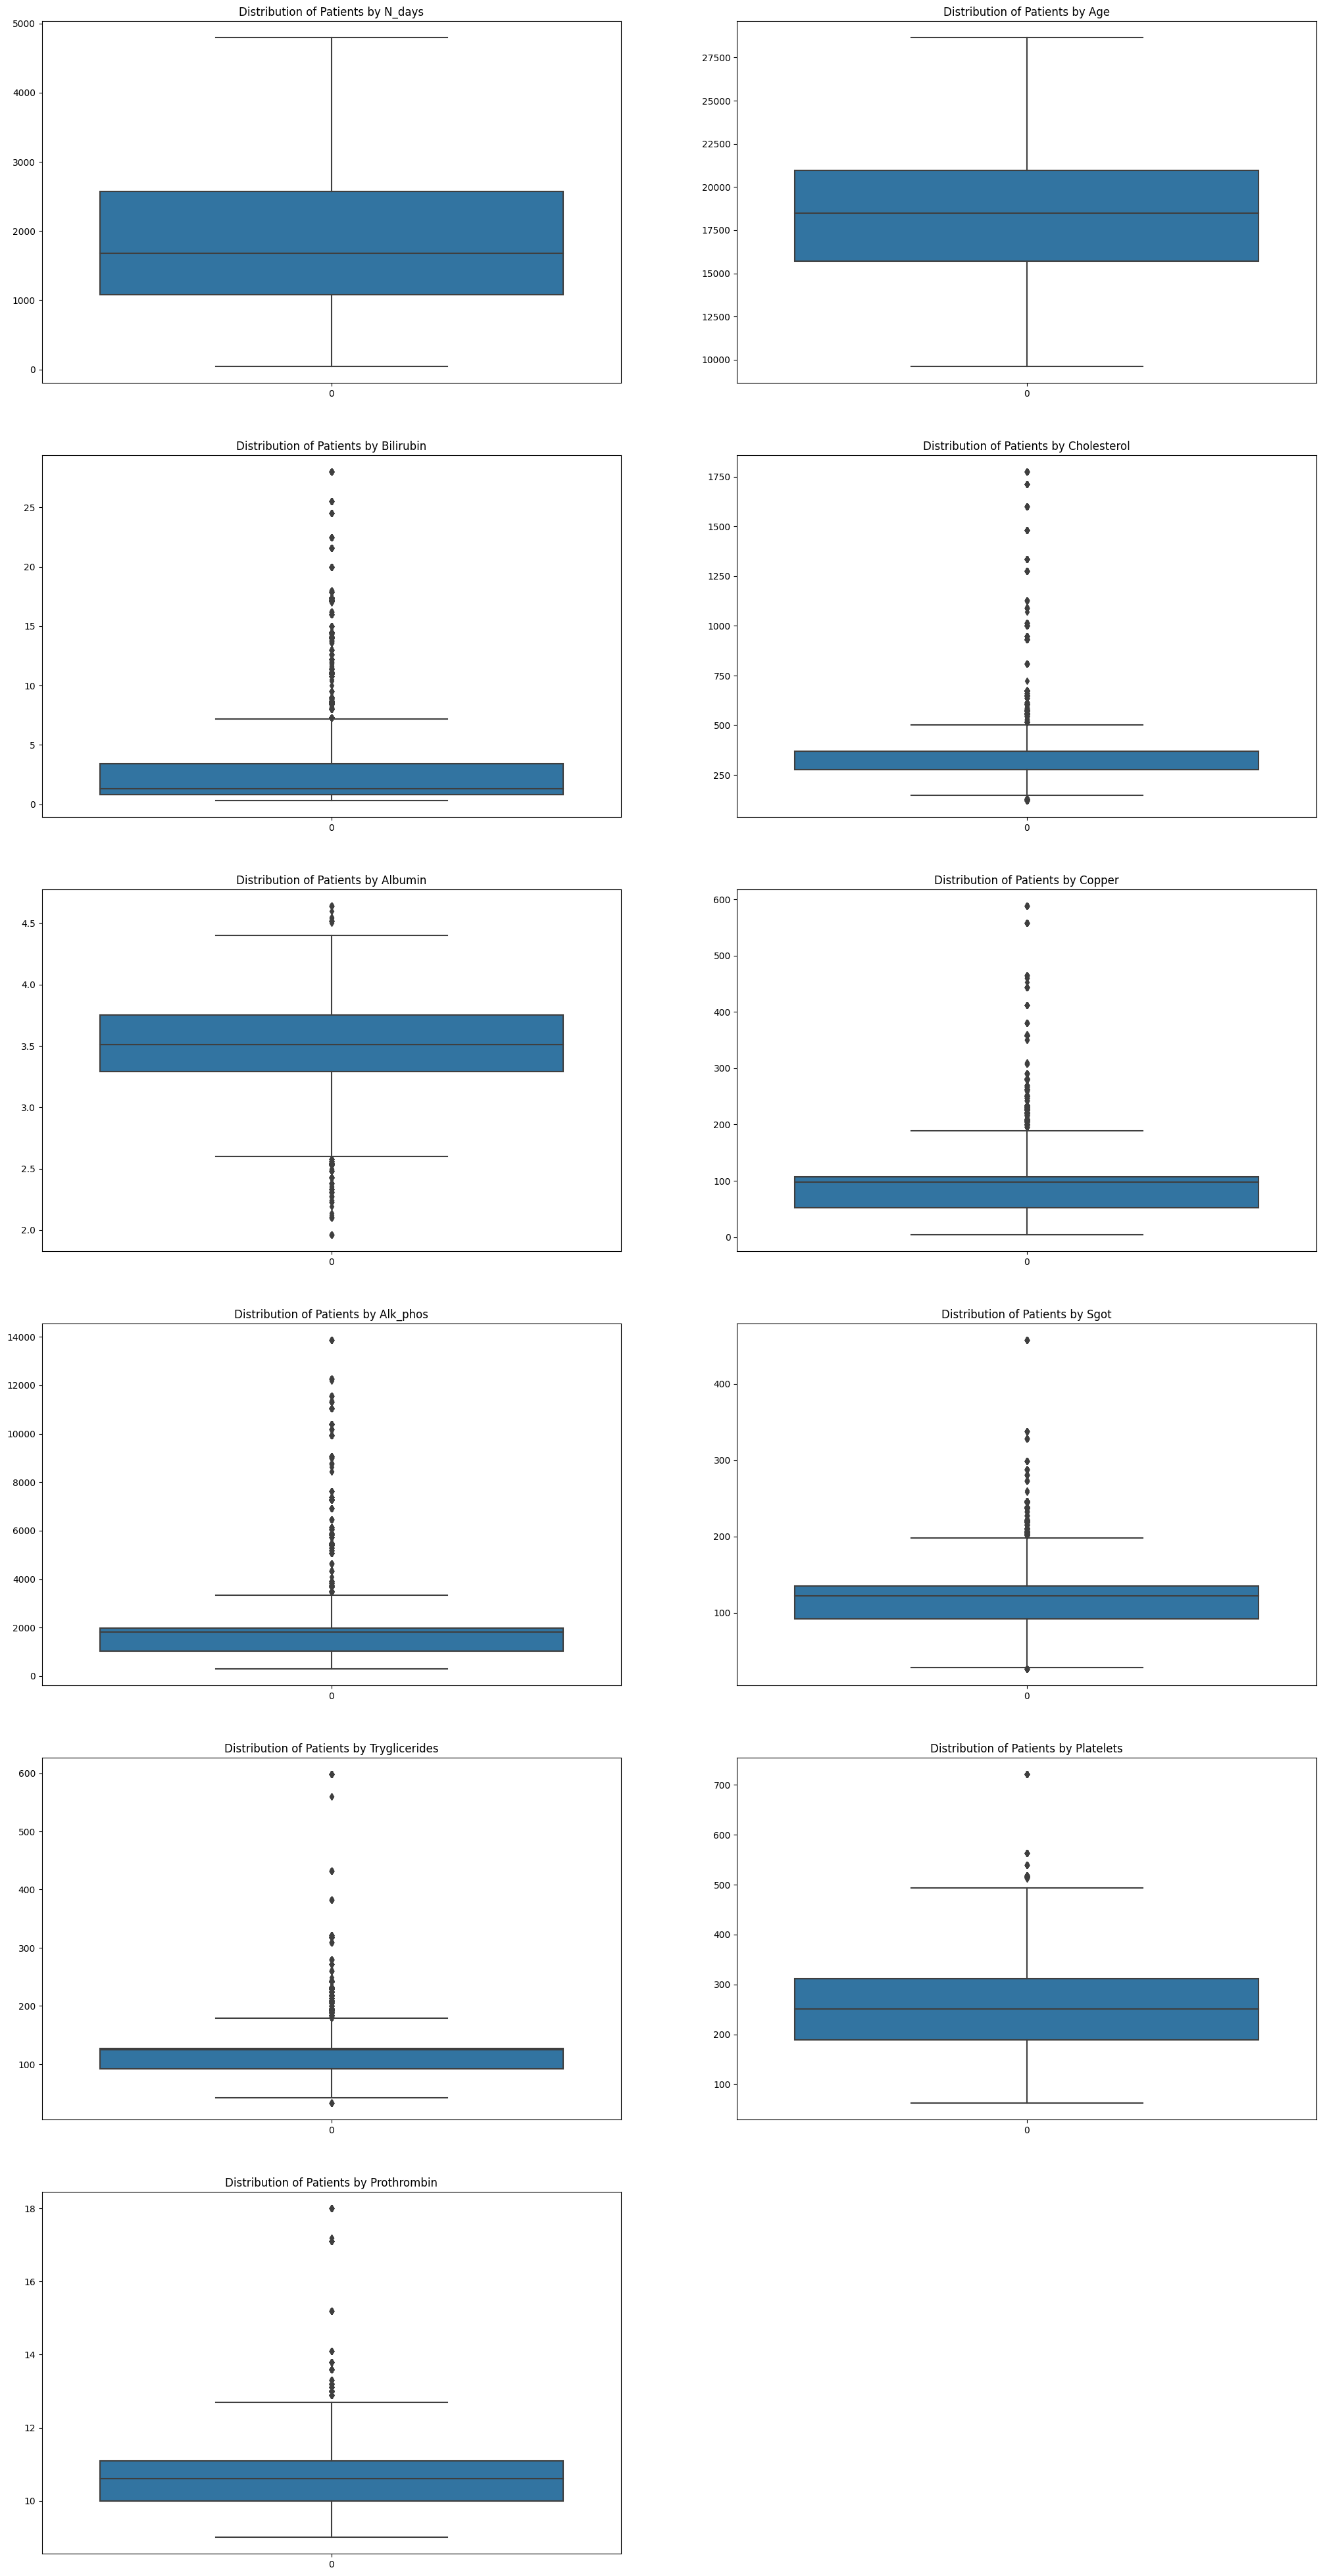

In [12]:
fig, axes = plt.subplots(nrows=round(len(numerical_cols)/2), ncols=2, figsize = (25,50))

# Iterate through each column and plot a countplot
for i, column in enumerate(numerical_cols):
   
    sns.boxplot(df[column],ax=axes[i//2,i%2])
    axes[i//2,i%2].set_title(f'Distribution of Patients by {column.capitalize()}')
    
    

# Hide any remaining empty subplots
for j in range(len(numerical_cols), len(axes.flat)):
    axes.flatten()[j].axis('off')

# BASIC FEATURE MANIPULATION AND MULTIVARIATE ANALYSIS

In [13]:
#CONVERTING AGE (IN DAYS) TO VALUES IN TERMS OF YEARS

df_copy = df.copy()

#TAKING 4 DECIMAL PLACES TO MAINTAIN PRECISION IN AGE

df_copy['age_yrs'] = round((df_copy['Age']/365), 4)

In [14]:
df_copy.drop(['Age'], axis = 1, inplace = True)
numerical_cols = df_copy.select_dtypes(exclude = 'O').columns.tolist()
categorical_cols = df_copy.select_dtypes('O').columns.tolist()

In [15]:
df_copy.groupby('Stage')[numerical_cols].median()

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,age_yrs
Stage,,,,,,,,,,,
1,2286.0,1.0,369.510563,3.61,97.648387,1692.000000,119.350000,124.702128,271.0,10.3,48.9699
2,1725.0,1.3,369.510563,3.56,97.648387,1812.000000,122.556346,124.702128,252.0,10.4,49.8603
3,1301.0,2.1,369.510563,3.40,97.648387,1982.655769,122.556346,124.702128,214.0,11.0,53.9671


In [16]:
df_copy.groupby('Stage')[numerical_cols].mean()

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,age_yrs
Stage,,,,,,,,,,,
1,2284.828554,2.473793,350.900239,3.554295,87.744561,1780.649417,110.767812,117.236957,285.558976,10.535287,49.326095
2,1922.650634,3.315283,402.436138,3.566402,101.302676,2050.772023,127.271112,126.638613,257.613371,10.496682,49.215582
3,1454.632747,4.417157,363.049538,3.337860,111.443439,2153.877000,131.344009,127.519137,224.924527,11.175197,53.500365


****Subjects in higher stage of Liver Cirrhosis have much higher Bilirubin, Copper, Alkaline Phosphatase than those in lower stage. ****

****Those who are older have a greater chance of developing Stage 3 Liver Cirrhosis. ****

****The N_days for Stage 3 subjects is also lower, suggesting more patients in Stage 3 had passed away or had transplantations. ****

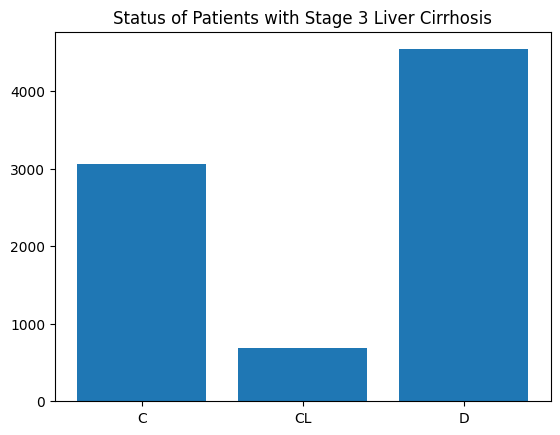

In [17]:
subjects_with_stage_3 = df_copy[df_copy.Stage == 3].groupby('Status').count()

plt.bar(x = subjects_with_stage_3['N_Days'].index, height = subjects_with_stage_3['N_Days'].values)
plt.title('Status of Patients with Stage 3 Liver Cirrhosis')
plt.show()

**Most subjects with Liver Cirrhosis Stage 3 passed away during the study and haven't completed the entire timeline of the study.******

In [18]:
df_copy.groupby('Sex')[numerical_cols].mean()

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,age_yrs
Sex,,,,,,,,,,,
F,1886.302254,3.400203,373.050688,3.482393,99.151371,1978.688322,123.176515,123.654476,259.023914,10.719557,50.152868
M,1893.417045,3.421516,366.770418,3.518942,108.174179,2127.022892,123.087711,125.122101,232.682861,10.850472,54.700281


In [19]:
df_copy.groupby('Sex')[numerical_cols].median()

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,age_yrs
Sex,,,,,,,,,,,
F,1690.0,1.3,369.510563,3.50,97.648387,1828.0,122.556346,124.702128,255.0,10.6,50.0356
M,1478.0,1.7,369.510563,3.52,97.648387,1919.0,122.556346,124.702128,217.0,10.9,53.3425


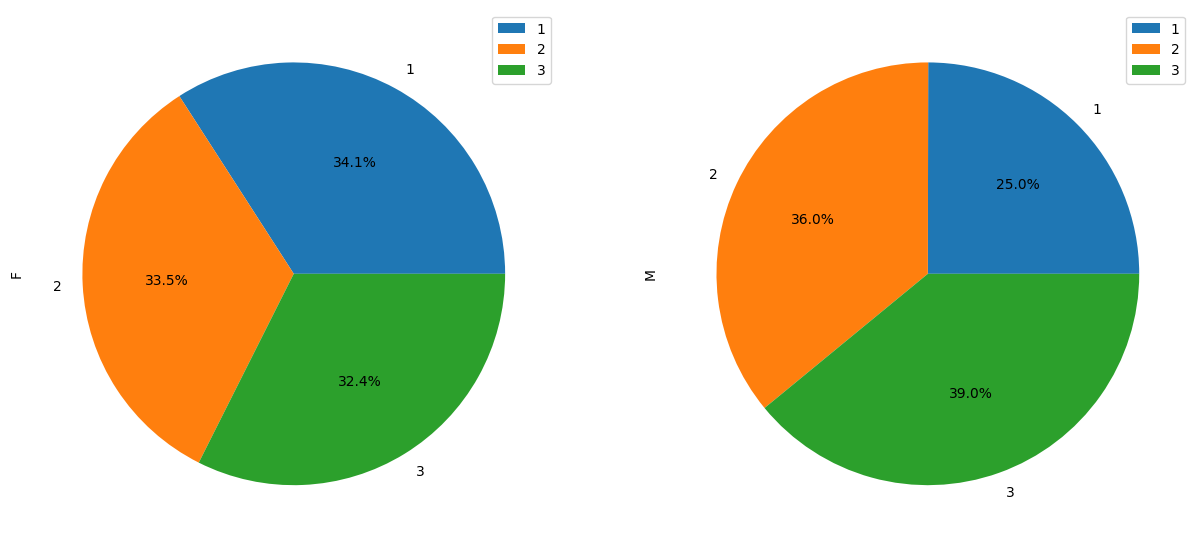

In [20]:
group_by_sex_and_stage = pd.crosstab(df_copy['Stage'],df_copy['Sex'])


group_by_sex_and_stage.plot(kind = 'pie', subplots = True, figsize = (15,15), autopct='%1.1f%%')
plt.show()

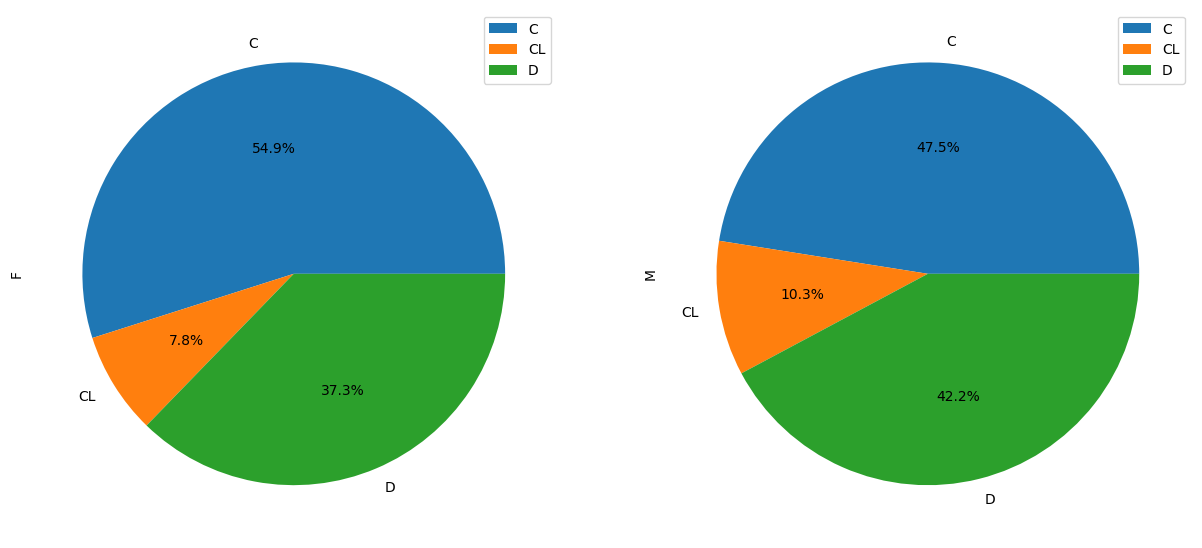

In [21]:
group_by_sex_and_status = pd.crosstab(df_copy['Status'],df_copy['Sex'])


group_by_sex_and_status.plot(kind = 'pie', subplots = True, figsize = (15,15), autopct='%1.1f%%')
plt.show()

<b> The Male Subjects, on average, have greater amount of Copper and Alk_Phos in their bodies. But, Females have more relatively more Platelets on average. </b>

<b> The Male Subjects are 4 years older than the Female subjects on average. </b>

<b> Majority of the Male subjects in the study suffered from Stage 3 Liver Cirrhosis. 39% had Stage 3, only 25% had Stage 1. That's why, Number of Deaths for Male Subjects in this study is greater in terms of percentage. </b>

<b> Female subjects have a more evenly distributed number of Stage 1,2, and 3 cases. </b>


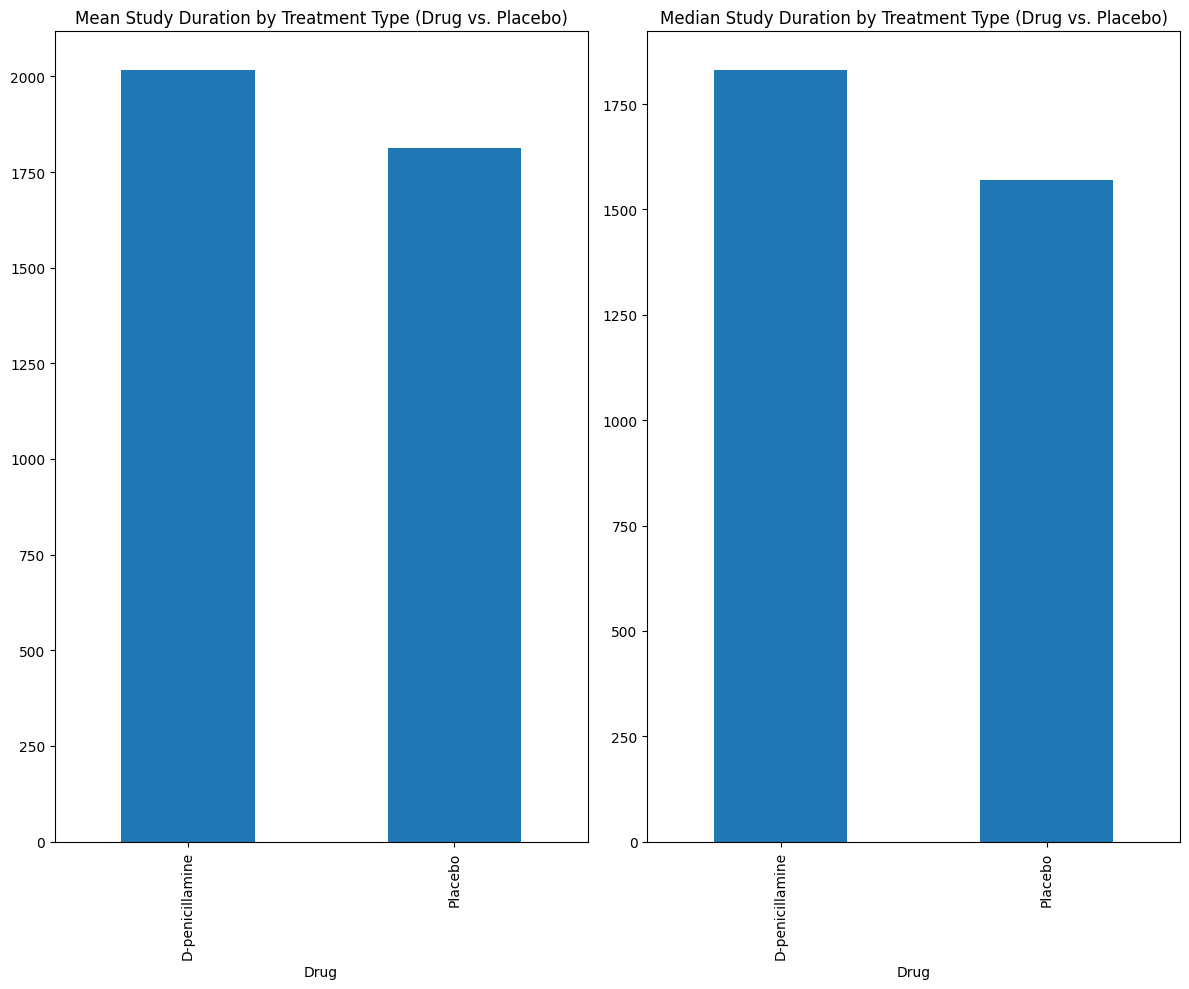

In [22]:
drugs_and_days = df_copy.groupby('Drug')['N_Days']

fig, axes = plt.subplots(1,2, figsize = (12,10))

drugs_and_days.mean().plot(kind = 'bar', ax = axes[0])
axes[0].set_title('Mean Study Duration by Treatment Type (Drug vs. Placebo)')

drugs_and_days.median().plot(kind = 'bar', ax = axes[1])
axes[1].set_title('Median Study Duration by Treatment Type (Drug vs. Placebo)')

plt.tight_layout()
plt.show()

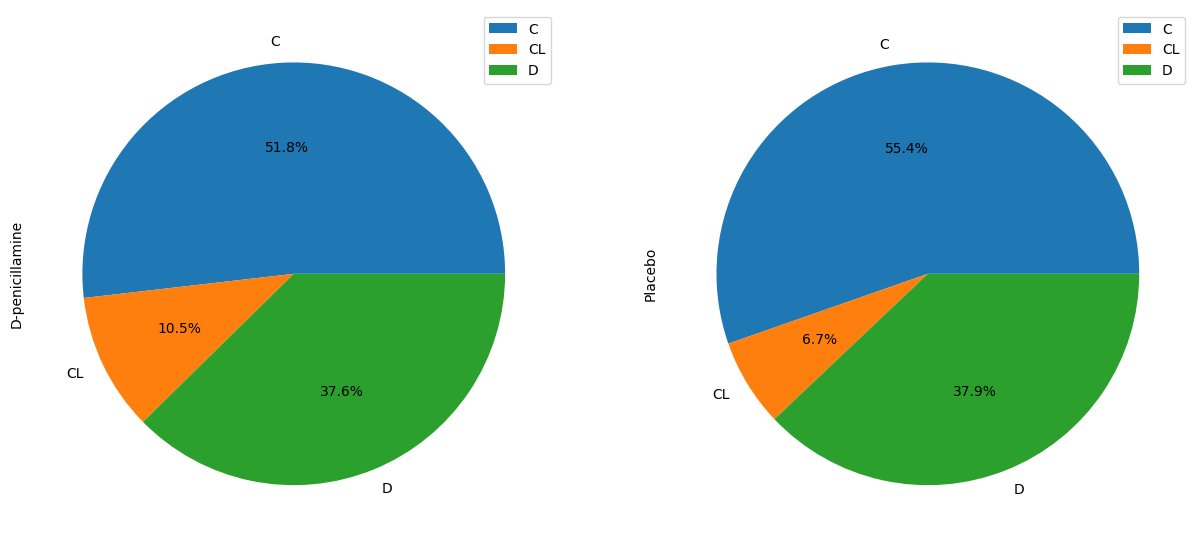

In [23]:
drugs_and_status = pd.crosstab(df_copy['Status'], df_copy['Drug'])

drugs_and_status.plot(kind = 'pie', subplots = True, autopct='%1.1f%%', figsize = (15,15))

plt.show()

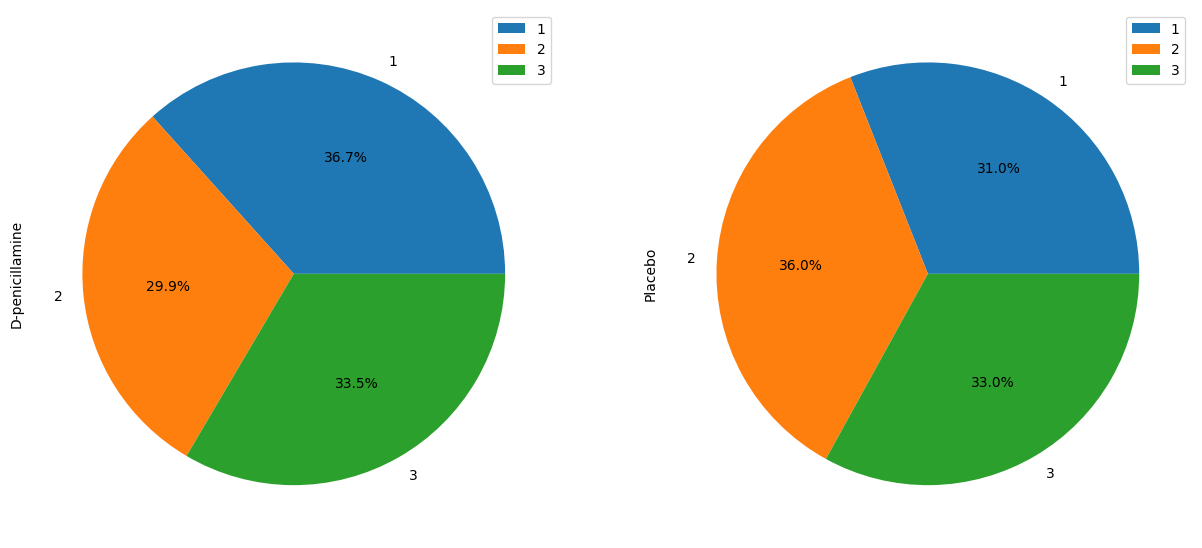

In [24]:
drugs_and_status = pd.crosstab(df_copy['Stage'], df_copy['Drug'])

drugs_and_status.plot(kind = 'pie', subplots = True, autopct='%1.1f%%', figsize = (15,15))

plt.show()

In [25]:
drugs_impact = df_copy.groupby('Drug')[numerical_cols].agg(['mean', 'median'])
drugs_impact.drop('age_yrs', axis = 1)

N_Days         Bilirubin        Cholesterol              \
                        mean  median      mean median        mean      median   
Drug                                                                            
D-penicillamine  2016.838112  1831.0  3.113529    1.4  369.791166  356.000000   
Placebo          1811.933405  1569.0  3.570209    1.3  373.803779  369.510563   

                 Albumin             Copper                Alk_Phos  \
                    mean median        mean     median         mean   
Drug                                                                  
D-penicillamine  3.50647   3.55   97.519168  80.000000  1982.973128   
Placebo          3.47505   3.49  101.729528  97.648387  2003.037683   

                                    SGOT             Tryglicerides  \
                      median        mean      median          mean   
Drug                                                                 
D-penicillamine  1622.000000  121.932355  122.450000    122.457133   
Placebo          1982.655769  123.881540  122.556346    124.613915   

                              Platelets        Prothrombin         
                     median        mean median        mean median  
Drug                                                               
D-penicillamine  124.000000  256.755995  251.0   10.703979   10.6  
Placebo          124.702128  255.573430  249.0   10.752267   10.6

1. <b>Subjects on drugs had higher N_Days than those on Placebo, suggesting that they were part of the study for much longer periods without having Liver Transplants or Death. </b>
2. <b>Subjects on the Drug had lower Cholesterol levels, Bilirubin, and Copper levels. </b>
3. <b>There were no significant impacts on the Prothrombin time. </b>

# BASIC DATA PREPROCESSING

In [26]:
X = df_copy.drop(['Stage'], axis =1 )
y = df_copy['Stage']

categorical_cols = X.select_dtypes('O').columns.tolist()
numerical_cols = X.select_dtypes(exclude = 'O').columns.tolist()

In [27]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_cols),
         ("StandardScaler", numeric_transformer, numerical_cols),        
    ]
)

In [28]:
X_scaled = preprocessor.fit_transform(X)
X_scaled

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.43532536e-05, -9.22747168e-01,  8.36205889e-04],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.64900891e-01,  7.23681910e-02,  3.28597014e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.14230538e-01, -8.12178794e-01, -1.78109585e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.54045307e+00,  2.50487240e+00, -4.70863180e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.72271763e+00,  1.82936564e-01, -4.02912530e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.72271763e+00,  1.82936564e-01, -4.02912530e-01]])

<h2> <b>  NOTE: Based on the domain (healthcare), the outliers and extreme values of Numerical Features in the dataset are equally important to normal data for the purpose of Liver Cirrhosis Stage Classification. That's why, the outliers are not eliminated and the data are kept consistent to the original dataset. </b> </h2>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

((20000, 27), (5000, 27))

In [30]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

# MODEL TRAINING

In [31]:
def evaluate_classification_model(true, predicted):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, average='weighted')
    recall = recall_score(true, predicted, average='weighted')
    f1 = f1_score(true, predicted, average='weighted')
    #roc_auc = roc_auc_score(true, predicted,average='macro')
    confusion = confusion_matrix(true, predicted)
    return accuracy, precision, recall, f1,  confusion


In [32]:
models = {
    "Logistic Regression": LogisticRegression(),
    #"Lasso": Lasso(),
    #"Ridge": Ridge(),
    "K-Neighbors Classifer": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Regressor": RandomForestClassifier(),
    "XGBRegressor": XGBClassifier(), 
    #"CatBoosting Regressor": CatBoostRegressor(verbose=False),
    #"AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]
best_f1_score = 0
best_model = None 

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train_encoded) # Train model
    
    
    
    y_test_encoded = label_encoder.transform(y_test)
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_acc , model_train_precision, _, model_train_f1, _ = evaluate_classification_model(y_train_encoded, y_train_pred)

    model_test_acc , model_test_precision, _, model_test_f1, _ = evaluate_classification_model(y_test_encoded, y_test_pred)

    current_model = list(models.keys())[i]
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_acc))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    #print("- ROC AUC Score: {:.4f}".format(model_train_roc_auc))

    print('----------------------------------')
    
    print('Model performance for Testing set')
    print("- Accuracy: {:.4f}".format(model_test_acc))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    #print("- ROC AUC Score: {:.4f}".format(model_test_roc_auc))
    #r2_list.append(model_test_f1)
    
    avg_f1_score = (model_train_f1 + model_test_f1)/2
    
    if avg_f1_score > best_f1_score:
        
        best_f1_score = avg_f1_score
        best_model = model
    
    print('='*35)
    print('\n')

Logistic Regression
Model performance for Training set
- Accuracy: 0.5914
- Precision: 0.5886
- F1 Score: 0.5895
----------------------------------
Model performance for Testing set
- Accuracy: 0.5994
- Precision: 0.5981
- F1 Score: 0.5986


K-Neighbors Classifer
Model performance for Training set
- Accuracy: 0.9273
- Precision: 0.9276
- F1 Score: 0.9273
----------------------------------
Model performance for Testing set
- Accuracy: 0.8956
- Precision: 0.8965
- F1 Score: 0.8959


Decision Tree
Model performance for Training set
- Accuracy: 0.9940
- Precision: 0.9940
- F1 Score: 0.9940
----------------------------------
Model performance for Testing set
- Accuracy: 0.9142
- Precision: 0.9143
- F1 Score: 0.9142


Random Forest Regressor
Model performance for Training set
- Accuracy: 0.9940
- Precision: 0.9940
- F1 Score: 0.9940
----------------------------------
Model performance for Testing set
- Accuracy: 0.9580
- Precision: 0.9582
- F1 Score: 0.9580


XGBRegressor
Model performance f

# FURTHER PERFORMANCE EVALUATION OF THE BEST MODEL

In [33]:
print(best_model)

RandomForestClassifier()


In [34]:
best_model.fit(X_train, y_train_encoded) # Train model

y_test_encoded = label_encoder.transform(y_test)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print (classification_report(y_test_pred, y_test_encoded))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1630
           1       0.97      0.95      0.96      1734
           2       0.97      0.97      0.97      1636

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



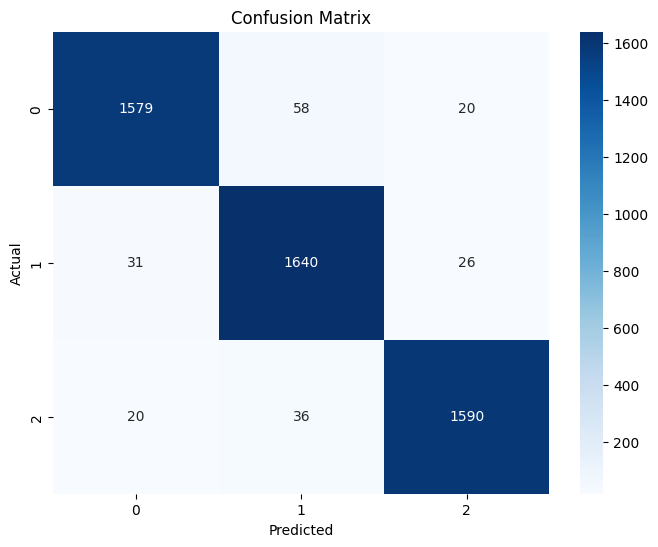

In [35]:
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()